In [12]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from astropy.time import Time
import os
from scipy.signal import lombscargle
from bokeh.palettes import viridis, inferno

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker, ColorBar, LinearColorMapper
output_notebook()

from bokeh.models import LogColorMapper, LogTicker, ColorBar
from astropy.timeseries import LombScargle

import matplotlib.pyplot as plt
#%matplotlib widget
# use seaborn for plot styles
import seaborn; seaborn.set()

Loading BokehJS ...

In [13]:
def getobjectdata(datafile,index,name='name'):
    command = "sed '{}q;d'  {}".format(index+1,datafile)
    print(command)
    datastring = ! {command}
    datalist = datastring[0].split()
    print(datalist[2:4])
    return datalist



def getvegamaganddates(data,columnfile,name):
    vegamagindex = np.arange(28,6568,13)
    
    
    vegamaglist = np.array([float(data[i]) for i in vegamagindex])
    vegamaglisterrors = np.array([float(data[i+2]) for i in vegamagindex])
    
    photometricflag = np.array([float(data[i+8]) for i in vegamagindex])
    
    columns = []
    with open(columnfile) as filecol:
        for line in filecol:
            columns.append(line)
    listanames = []
    dates = []
    times =[]
    nameobject = []
    namel=[]

    for i in vegamagindex:
        initname = columns[i].find('Try/u')
        namefits = columns[i][initname:initname+23]
        listanames.append(namefits)
        fit = fits.open(namefits+'.fits')
        dates.append(fit[0].header['DATE-OBS'])
        times.append(fit[0].header['TIME-OBS'])
        namel.append(name)
    datesobs = [['{}T{}'.format(i,j)] for i,j in zip(dates,times)]

    d = np.array(datesobs)
    t = Time(d)
    namel = np.array(namel)
       
    return vegamaglist, vegamaglisterrors,t, d, namel, photometricflag


def createdatadiccomplete(data,columnfile):
    vegamag,vegamagerrros, timelist, observationname = getvegamaganddates(data,columnfile)
    datadic = {'time':timelist.datetime64,
               'VEGAMAG':vegamag,
               'obnames':observationname,
                'errorsmag':vegamagerrros}
    return datadic
            



def createdatadicclean(datafile,index,columnfile,name='name',timeformat='datetime64'):
    dataobject = getobjectdata(datafile,index)
    vegamag,vegamagerrros, timelist, observationname, namelist, photometricflag = getvegamaganddates(dataobject,columnfile,name)
    goodvegamagindex = np.where(vegamag < 99)[0]
    goodphotoindex = np.where(photometricflag == 0.)
    goodindex = np.intersect1d(goodvegamagindex,goodphotoindex)
    print(len(goodindex))
    if timeformat == 'datetime64':
        timelist2 = timelist.datetime64[goodindex]
    elif timeformat == 'mjd':
        timelist2 = timelist.mjd[goodindex]

    datadic = {'time':np.array(timelist2.flatten()),
               'VEGAMAG':vegamag[goodindex],
               'obnames':observationname[goodindex],
                'errorsmag':vegamagerrros[goodindex],
               'upper':vegamag[goodindex] + vegamagerrros[goodindex] ,
              'lower':vegamag[goodindex] - vegamagerrros[goodindex],
              'name':namelist[goodindex]}
    return datadic


def plotlb(outputfile,index,columnfile,name='',plot=True,getarg=False,periods=np.linspace(0.2, 1.4, 4000)):
    datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']

        # Choose a period grid
    periods = periods
    #periods = np.linspace(0.2, 1.4, 4000)
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    power = lombscargle(t.flatten(), mag - mag.mean(), ang_freqs,normalize=False,precenter=True)

    # normalize the power
    N = len(t.flatten())
    #power *= 2 / (N * mag.std() ** 2)
    if plot == True:
        # plot the results
        fig, ax = plt.subplots()
        ax.plot(periods, power)
        ax.set(ylim=(0, 0.8), xlabel='period (days)',
               ylabel='Lomb-Scargle Power');
    if getarg == True:
        return periods, power,t,mag,dmag

def plotlc(outputfile,indexlist,columnfile,namelist=''):
    colorlist = ['red','blue','green','yellow']
    p = figure(plot_width=900, plot_height=500, title='',active_drag='pan', active_scroll='wheel_zoom',
                  x_axis_type='datetime',y_axis_label='VEGAMAG',x_axis_label='Date_Obs')
    
    
    for i,indexnumber in enumerate(indexlist):
        color = colorlist[i]
        
        datagood = createdatadicclean(outputfile,indexnumber,columnfile,name=namelist[i])

        source = ColumnDataSource(data=datagood)
   


        


        #Tool to get wavelength
        hover2 = HoverTool(
                tooltips=[
                    ('Date', '(@obnames)')
                ]
            )


        p.add_tools(hover2)



        # add a circle renderer with a size, color, and alpha
        p.circle('time','VEGAMAG', source=source, color=color, name='name',legend='name')
        p.add_layout(
            Whisker(source=source, base="time", upper="upper", lower="lower")
        )


    p.y_range.flipped = True



    show(p)

def plotphase(outputfile,index,columnfile,name='',plot=False,periodmax=99.99, periods=np.linspace(0.2, 1.4, 4000),returnarg=False):
    nameob= name
    periods,power,t,mag,dmag = plotlb(outputfile,index,columnfile,name=nameob,plot=plot,getarg=True,periods=periods)
    #datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    #t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']
    indexmax = np.where(power == power.max())
    #print(periods)
    if periodmax == 99.99:
        periodmax = periods[indexmax]
    print(periodmax)

    # Compute phases of the obsevations
    phase = (t.flatten() / periodmax) % 1

    # Plot the phased data & model
    fig, ax = plt.subplots()

    
    ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
    ax.invert_yaxis();
    plt.show()
    if returnarg:
        return phase,mag,dmag, t.flatten()
    
    
def plotlcseaborn(outputfile,index,columnfile,name='',invertaxis = False):
    datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']

    
    
    fig, ax = plt.subplots()


    ax.errorbar(t, mag, dmag,  fmt='.k', ecolor='gray')
    ax.set(xlabel='Time (days)', ylabel='magitude',
           title=datagoodmjd['name'][0])
    if invertaxis == True:
        ax.invert_yaxis();
    plt.show()

In [36]:
def getobjectdata(datafile,index,name='name'):
    command = "sed '{}q;d'  {}".format(index+1,datafile)
    print(command)
    datastring = ! {command}
    datalist = datastring[0].split()
    print(datalist[2:4])
    return datalist



In [37]:
a = getobjectdata(outputfile,737,name='a')

sed '738q;d'  outdir/out.photo
['515.39', '125.65']


In [55]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    print(a[36+13*i])

9
0
9
9
9
0
9
9
9
0
9
9
9
0
9


In [57]:
vegamagindex = np.arange(28,6568,13)

photometricflag = np.array([float(a[i+8]) for i in vegamagindex])
photometricflag

array([9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9.,
       9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9.,
       0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0.,
       9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 2., 9., 9., 9., 2., 9.,
       9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 2., 9., 9.,
       9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9.,
       0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0.,
       9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 2., 9., 9., 9., 0., 9.,
       9., 9., 2., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9.,
       9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9.,
       2., 9., 9., 9., 0., 9., 9., 9., 2., 9., 9., 9., 0., 9., 9., 9., 0.,
       9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 0., 9.,
       9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 2., 9., 9., 9., 2., 9., 9.,
       9., 0., 9., 9., 9.

In [58]:
np.where(photometricflag == 2.)

(array([ 62,  66,  82, 130, 138, 170, 178, 214, 218, 254, 258, 298, 362,
        386]),)

In [14]:
outputfile = 'outdir/out.photo'
columnfile = 'outdir/out.columns'


# From the postion of the CMD and Cohn picture of the paper I think that U18 is the one below. So 737 for DOLPHOT

![](images/U182.png)

In [15]:
plotlc(outputfile,[737,230],columnfile,namelist=['737','230'])
plotlc(outputfile,[737],columnfile,namelist=['737'])



sed '738q;d'  outdir/out.photo
['515.39', '125.65']
112
sed '231q;d'  outdir/out.photo
['512.14', '128.26']
126


sed '738q;d'  outdir/out.photo
['515.39', '125.65']
112


In [16]:
datagoodmjd=  createdatadicclean(outputfile,737,columnfile,name='737',timeformat='mjd')
mjd, mag, dmag, obnames = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag'], datagoodmjd['obnames']

sed '738q;d'  outdir/out.photo
['515.39', '125.65']
112


# Compute Periodogram with Astropy

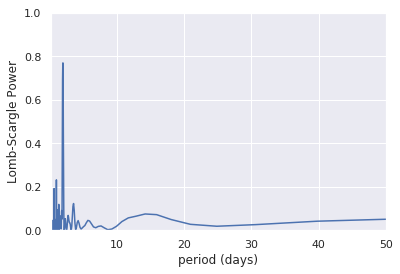

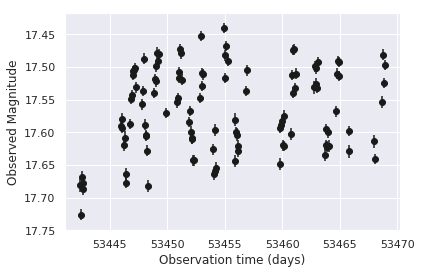

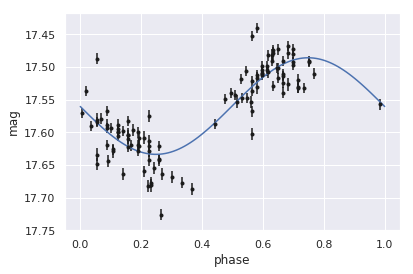

In [32]:


freq, PLS = LombScargle(mjd, mag, dmag).autopower(minimum_frequency=1 / 100.,
                                                maximum_frequency=1 / 0.1)
best_freq = freq[np.argmax(PLS)]
phase = (mjd * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1,len(mjd))
mag_fit = LombScargle(mjd, mag, dmag).model(t=phase_fit / best_freq,
                                          frequency=best_freq)
# plot the periodogram

fig, ax = plt.subplots()

plt.plot(1. / freq, PLS)
ax.set(xlabel='period (days)',
          ylabel='Lomb-Scargle Power',
          xlim=(0.2, 50),
          ylim=(0, 1));
plt.show()


fig, ax = plt.subplots()

# plot the raw data
ax.errorbar(mjd, mag, dmag, fmt='ok', elinewidth=1.5, capsize=0)
ax.invert_yaxis()
ax.set(   xlabel='Observation time (days)',
          ylabel='Observed Magnitude')

#plt.plot(t,mag_fit)



fig, ax = plt.subplots()
# plot the phased data & model in the inset
plt.errorbar(phase, mag, dmag, fmt='.k', capsize=0)
plt.plot(phase_fit, mag_fit)


ax.invert_yaxis()
ax.set_xlabel('phase')
ax.set_ylabel('mag')
plt.show()

In [33]:
best_freq = freq[np.argmax(PLS)]

summary = 'Best_frequency: {}, Period: {} days'.format(best_freq,1/best_freq)
print(summary)
p1 = figure(plot_width=900, plot_height=500, title=summary,active_drag='pan', active_scroll='wheel_zoom',y_axis_label='Power',x_axis_label='Period (days)')
p2 = figure(plot_width=900, plot_height=500, title='',active_drag='pan', active_scroll='wheel_zoom',y_axis_label='Power',x_axis_label='Freq (1/days)')


#source1 = ColumnDataSource(data={'power':PLS,
#                              'period': 1./freq})

period = 1./freq
source1 = ColumnDataSource(data={'power':PLS,
                              'period':1./freq,
                                'freq':freq})

#Tool to get wavelength
hover1 = HoverTool(
        tooltips=[
            ('Period', '(@period{0.0000}'),
            ('Frequency', '(@freq{0.000})')
        ]
    )


p1.add_tools(hover1)
p2.add_tools(hover1)



# add a circle renderer with a size, color, and alpha

p1.line('period','power',source=source1)
p2.line('freq','power',source=source1)

show(p1)
show(p2)

Best_frequency: 0.5088321742553623, Period: 1.9652845291542833 days


In [34]:
#
from bokeh.resources import CDN
from bokeh.plotting import figure
from bokeh.embed import autoload_static
name= 'u18periodogram'



#Js is a js file that provides data for the plot and the tag is the tag to include in the html document.
#js, tag= components(p1)
js,tag = autoload_static(p2, CDN, "images/"+name+".js")

##To save it in files
with open(name+'.js','w') as jsfile:
	jsfile.write(js)
with open(name+'.html','w') as htmlfile:
	htmlfile.write(tag)
#

In [35]:
colorlist = viridis(len(mjd))
colorlist = inferno(len(mjd))




p = figure(plot_width=900, plot_height=500, title=summary,active_drag='pan', active_scroll='wheel_zoom',y_axis_label='VEGAMAG',x_axis_label='Phase')


source = ColumnDataSource(data={'phase':phase,
                                'VEGAMAG':mag,
                                'dmag':dmag,
                                'mjd':mjd,
                               'upper':mag + dmag ,
              'lower':mag - dmag })
  


#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@mjd{0.0000})')
        ]
    )


p.add_tools(hover2)


# add a circle renderer with a size, color, and alpha
p.add_layout(
    Whisker(source=source, base="phase", upper="upper", lower="lower")
)

p.line(phase_fit, mag_fit)
p.y_range.flipped = True


mapper = LinearColorMapper(palette=colorlist, low=mjd.min(), high=mjd.max())

#mapper.low_color = 'blue'
#mapper.high_color = 'red'

color_bar = ColorBar(color_mapper=mapper, location=(0, 0.5),title='MJD')

p.circle('phase','VEGAMAG',source=source,color={'field': 'mjd', 'transform': mapper})


p.add_layout(color_bar, 'right')
#@date{%F}'

show(p)

# Save data

In [ ]:
datagoodnonmjd  = createdatadicclean(outputfile,737,columnfile,name='737')
np.save('mjdu18',mjd)
np.save('magu18',mag)
np.save('dmagu18',dmag)
np.save('obnamesu18',obnames)
np.save('timeu18',datagoodnonmjd['time'])

sed '738q;d'  outdir/out.photo
['515.39', '125.65']
112
